Lets simulate a CRN. We can run a loop for a set number of iterations where each iteration the sensor network can allocate channels to a primary user and secondary users can sense(query) and use unused channels, how they use the channel will affect their trustValue as assessed by other users. Every some number of iterations all the users will use trimessage communication to synchronize their trust values. Each iteration a fraction of secondary users can also try to be malicious by giving other users lower trust scores, giving themself a high trust score, or lying about whether the primary user is in the channel. Since we don't have a data fusion center, other users will have to "catch" these lies and adjust trust scores accordingly.

In [1]:
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

num_iterations = 10
malicious_proportion = 0.2


class SensorNetwork:
    """
    Can only read values from nodes, not write them (decentralized network)
    - Know if primary user is active
    - Know what Secondary Users exist, and what they believe/do
    """
    users = []  # devices in the network
    data = []  # row 0 to n - 1 = SU; z0 = channel use, z1=belief
    clock = 0

    def __init__(self, user_list, primary_user):
        self.users = user_list
        self.primary_user = primary_user
        self.data = np.zeros(shape=(len(users), num_iterations, 3))

    def update_users(self):
        """
        Advance each Secondary User's clock one step
        :return:
        """
        signal = random.randint(0, 1)
        self.data[0, self.clock, 0] = signal

        # Broadcast current beliefs to neighbors
        for user in self.users:
            user.update(self.clock, self.primary_user_strength(user, signal))

        # Update personal beliefs based on information received from neighbors, vote
        for user in self.users:
            user.update_pu_belief()
            user.update_trust_values()
            user.update_pu_belief()
            user.vote()

        # Tally votes, collect state information
        for index, user in enumerate(self.users):
            user.tally_votes()
            self.data[index, self.clock, 0] = user.is_channel_allocated()
            self.data[index, self.clock, 1] = user.is_primary_active()
            self.data[index, self.clock, 2] = user.get_trust_values()[index]

        self.clock += 1

    def get_data(self):
        return self.data

    def primary_user_strength(self, user, signal):
        distance = math.sqrt((user.x - self.primary_user.x) ** 2 + (user.y - self.primary_user.y) ** 2)
        noise = (random.random() - 0.5) / 4
        return signal + noise * distance ** 2


class PrimaryUser:
    x = 0
    y = 0

    def __init__(self, x, y):
        self.x = x
        self.y = y


class SecondaryUser:
    """
    A "good faith" SU, no malicious behavior
    """
    x = 0  # x position
    y = 0  # y position
    clock = 0  # Keeps track of the logical time for a device
    id = 0  # This user's id for distinguishability
    channel_allocated = False  # Boolean, is the channel allocated for this device
    primary_user_value = False  # The belief on whether or not primary user is in the channel
    neighbors = []  # neighbors this device can broadcast to
    trust_values = {}  # The perceived trust values of other users
    received_activity = {}  # Received values for activity of primary user in this epoch
    received_trust = {}  # Received values for trustworthiness of other users in this epoch
    ballot = {}  # Received votes for bandwidth allocation in this epoch

    def __init__(self, id_val, x, y):
        self.id = id_val
        self.x = x
        self.y = y

    def set_neighbors(self, neighbors):
        self.neighbors = neighbors
        self.trust_values = {neighbor.id: 1 / len(neighbors) for neighbor in neighbors}

    # Inspired by the following StackOverflow thread
    # https://stackoverflow.com/questions/10324015/fitness-proportionate-selection-roulette-wheel-selection-in-python
    def vote(self):
        choice = random.choices(self.neighbors, weights=self.trust_values)[0]
        for neighbor in self.neighbors:
            neighbor.receive_vote(choice)
        self.received_activity = {}
        self.received_trust = {}

    def receive_vote(self, node):
        if node.id in self.ballot:
            self.ballot[node.id] += 1
        elif len(self.ballot.keys()) > 2:
            pop_list = []
            for key in self.ballot.keys():
                if self.ballot[key] > 1:
                    self.ballot[key] -= 1
                else:
                    pop_list.append(key)
            for key in pop_list:
                self.ballot.pop(key)
        else:
            self.ballot[node.id] = 1

    def tally_votes(self):
        for idx, votes in self.ballot.items():
            if idx == self.id and not self.primary_user_value:
                self.channel_allocated = True

    def update(self, clock, primary_user_value):
        self.channel_allocated = False
        self.clock = clock
        self.primary_user_value = int(primary_user_value > 0.5)
        self.ballot = {}
        self.broadcast()

    def update_trust_values(self):
        """
        Communicate/receive trust values from other users.
        Ignore broadcast procedures, they can get values from other users at any time.
        """
        neighbor_ids = [neighbor.id for neighbor in self.neighbors]

        trust_df = pd.DataFrame(self.received_trust)
        trust_df['average'] = trust_df.mean(axis=0)

        new_trust_values = {}

        for idx in trust_df.columns:
            if idx in neighbor_ids:
                sse_trust = ((trust_df[idx] - trust_df['average']) ** 2).mean() ** 0.5
                disagreement_penalty = -int(self.received_activity[idx] != self.primary_user_value)
                new_trust_values[idx] = self.trust_values[
                                           idx] * 0.6 + 0.2 * 1.1 ** -sse_trust + 0.2 * disagreement_penalty

        sum_new_trust = sum(new_trust_values.values())
        self.trust_values = {idx: value / sum_new_trust for idx, value in new_trust_values.items()}

    def update_pu_belief(self):
        weighted_avg = sum(self.trust_values[neighbor.id] * self.received_activity[neighbor.id] for neighbor in
                           self.neighbors) * 0.8 + 0.2 * self.primary_user_value
        self.primary_user_value = weighted_avg > 0.5

    def broadcast(self):
        """
        Broadcast values to all other users
        """
        # For all users in the network, make them recieve
        # the trust values of this particular instance
        for neighbor in self.neighbors:
            neighbor.receive_broadcast(self.id, self.trust_values, self.primary_user_value)

    def receive_broadcast(self, sender_id, trust_values, pu_presence):
        """
        Recieve a broadcast of trust values from another device and update
        the instance's trust values accordingly
        """
        # compare the nodes trust values and use that as a weight to update the trust
        # values of the device
        self.received_trust[sender_id] = trust_values
        self.received_activity[sender_id] = pu_presence

    def is_channel_allocated(self):
        """:
        return: boolean true if channel is allocated to this SU
        """
        return self.channel_allocated

    def is_primary_active(self):
        """
        :return: boolean true if channel is believed to be allocated to PU
        """
        return self.primary_user_value

    def get_trust_values(self):
        """
        :return: int the trust value
        """
        return self.trust_values


class MaliciousUser(SecondaryUser):
    """
    Users with potential to be malicious, some strategy:
    -Selfish SSDF: Falsely report that PU is present, in order to gain exclusive access to the desired
    spectrum.
    - Interference SSDF: Falsely report that PU is not present, in order to cause interference to PU.
    - Confusing SSDF: Randomly reports a true or false value for primary user energy, preventing a
    consensus.
    """

    def broadcast(self):
        for neighbor in self.neighbors:
            neighbor.receive_broadcast(self.id, self.trust_values, not self.primary_user_value)

    def SelfishSSDF(self):
        if not self.is_primary_active():
            self.primary_user_value = True

    def InterferenceSSDF(self):
        if self.is_primary_active():
            self.primary_user_value = False

    def ConfusingSSDF(self):
        z = random.random()
        if z < 0.5:
            self.primary_user_value = True
        else:
            self.primary_user_value = False


def generate_point(mean_x, mean_y, deviation_x, deviation_y):
    return random.gauss(mean_x, deviation_x), random.gauss(mean_y, deviation_y)


def discover_neighbors(node, user_list):
    import scipy.spatial as spatial

    points = np.array([(user.x, user.y) for user in user_list])
    point_tree = spatial.cKDTree(points)
    neighbor_indices = point_tree.query_ball_point((node.x, node.y), 0.3)
    return [user_list[idx] for idx in neighbor_indices]


def initializeUsers():
    new_users = []
    # Add 1 primary User
    # Add Secondary Users to network
    cluster_mean_x = 1
    cluster_mean_y = 1
    cluster_deviation_x = 0.5
    cluster_deviation_y = 0.5
    point_deviation_x = 0.2
    point_deviation_y = 0.2

    number_of_clusters = 3
    points_per_cluster = 20

    cluster_centers = [generate_point(cluster_mean_x,
                                      cluster_mean_y,
                                      cluster_deviation_x,
                                      cluster_deviation_y)
                       for _ in range(number_of_clusters)]

    points = [generate_point(center_x,
                             center_y,
                             point_deviation_x,
                             point_deviation_y)
              for center_x, center_y in cluster_centers
              for _ in range(points_per_cluster)]

    malicious_user_idx = []
    for idx, p in enumerate(points):
        x = random.random()
        if x > malicious_proportion:
            new_users.append(SecondaryUser(idx, p[0], p[1]))
        else:
            new_users.append(MaliciousUser(idx, p[0], p[1]))
            malicious_user_idx.append(idx)

    for user in new_users:
        user.set_neighbors(discover_neighbors(user, new_users))
    return new_users, malicious_user_idx


def plot_users(users, primary_user, malicious_users):
    plt.scatter([user.x for user in users], [user.y for user in users])
    plt.scatter(primary_user.x, primary_user.y, c="red")
    plt.scatter([users[i].x for i in malicious_users], [users[i].y for i in malicious_users], c="yellow")
    plt.show()


if __name__ == '__main__':
    users, malicious_users = initializeUsers()
    primary = PrimaryUser(1, 1)
    net = SensorNetwork(users, primary)
    for i in range(num_iterations):
        net.update_users()
    plot_users(users, primary, malicious_users)
    data = net.get_data()
    print([data[x] for x in malicious_users])


<Figure size 640x480 with 1 Axes>

[array([[ 0.00000000e+00,  0.00000000e+00,  3.30334873e-02],
       [ 0.00000000e+00,  0.00000000e+00,  9.29678863e-03],
       [ 0.00000000e+00,  1.00000000e+00,  2.03696505e-03],
       [ 0.00000000e+00,  0.00000000e+00, -1.86015619e-04],
       [ 0.00000000e+00,  1.00000000e+00, -8.66903251e-04],
       [ 0.00000000e+00,  0.00000000e+00, -1.07547377e-03],
       [ 0.00000000e+00,  0.00000000e+00, -1.13936533e-03],
       [ 0.00000000e+00,  0.00000000e+00, -1.15893757e-03],
       [ 0.00000000e+00,  0.00000000e+00, -1.16493330e-03],
       [ 0.00000000e+00,  0.00000000e+00, -1.16677003e-03]]), array([[ 0.00000000e+00,  0.00000000e+00,  1.63807363e-02],
       [ 0.00000000e+00,  0.00000000e+00,  3.21785682e-03],
       [ 0.00000000e+00,  1.00000000e+00,  3.51414563e-04],
       [ 0.00000000e+00,  0.00000000e+00, -2.73363900e-04],
       [ 0.00000000e+00,  1.00000000e+00, -4.09635814e-04],
       [ 0.00000000e+00,  0.00000000e+00, -4.39389272e-04],
       [ 1.00000000e+00,  0.00000000e

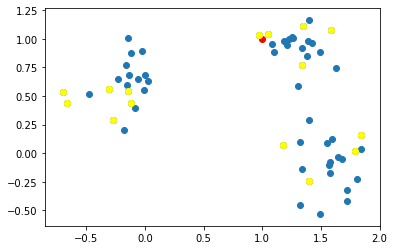

In [2]:
plot_users(users, primary, malicious_users)

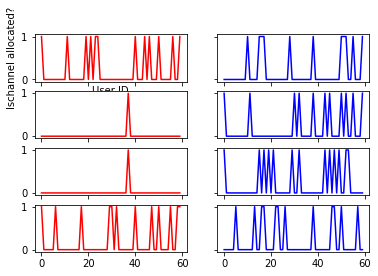

In [7]:
#channel allocated beliefs for specific iterations
data = net.get_data()
x = np.arange(0, 60)
fig, ax = plt.subplots(4, 2, sharex='col', sharey='row')
ax[0][0].set_xlabel('User ID')
ax[0][0].set_ylabel('Ischannel allocated?')

ax[0][0].plot(x, data[0:60,0,0], c = "r")
ax[0][1].plot(x, data[0:60,1,0], c = "b")
ax[1][0].plot(x, data[0:60,2,0], c = "r")
ax[1][1].plot(x, data[0:60,3,0], c = "b")

ax[2][0].plot(x, data[0:60,4,0], c = "r")
ax[2][1].plot(x, data[0:60,5,0], c = "b")
ax[3][0].plot(x, data[0:60,6,0], c = "r")
ax[3][1].plot(x, data[0:60,7,0], c = "b")

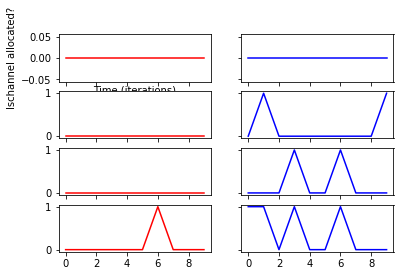

In [8]:
#channel allocated beliefs for specific users
# red is malicious
#blue is normal
data = net.get_data()
x = np.arange(0, 10)
fig, ax = plt.subplots(4, 2, sharex='col', sharey='row')
ax[0][0].set_xlabel('Time (iterations)')
ax[0][0].set_ylabel('Ischannel allocated?')

ax[0][0].plot(x, data[8,0:10,0], c = "r")
ax[0][1].plot(x, data[3,0:10,0], c = "b")
ax[1][0].plot(x, data[18,0:10,0], c = "r")
ax[1][1].plot(x, data[10,0:10,0], c = "b")

ax[2][0].plot(x, data[25,0:10,0], c = "r")
ax[2][1].plot(x, data[30,0:10,0], c = "b")
ax[3][0].plot(x,data[58,0:10,0], c = "r")
ax[3][1].plot(x, data[59,0:10,0], c = "b")

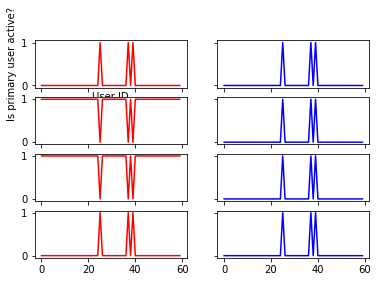

In [9]:
#primary user active beliefs for specific iterations
data = net.get_data()
x = np.arange(0, 60)
fig, ax = plt.subplots(4, 2, sharex='col', sharey='row')
ax[0][0].set_xlabel('User ID')
ax[0][0].set_ylabel('Is primary user active?')

ax[0][0].plot(x, data[0:60,0,1], c = "r")
ax[0][1].plot(x, data[0:60,1,1], c = "b")
ax[1][0].plot(x, data[0:60,2,1], c = "r")
ax[1][1].plot(x, data[0:60,3,1], c = "b")

ax[2][0].plot(x, data[0:60,4,1], c = "r")
ax[2][1].plot(x, data[0:60,5,1], c = "b")
ax[3][0].plot(x, data[0:60,6,1], c = "r")
ax[3][1].plot(x, data[0:60,7,1], c = "b")

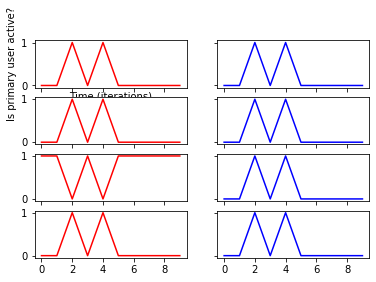

In [10]:
#primary user active beliefs for specific users
# red is malicious
#blue is normal
data = net.get_data()
x = np.arange(0, 10)
fig, ax = plt.subplots(4, 2, sharex='col', sharey='row')
ax[0][0].set_xlabel('Time (iterations)')
ax[0][0].set_ylabel('Is primary user active?')

ax[0][0].plot(x, data[8,0:10,1], c = "r")
ax[0][1].plot(x, data[3,0:10,1], c = "b")
ax[1][0].plot(x, data[18,0:10,1], c = "r")
ax[1][1].plot(x, data[10,0:10,1], c = "b")

ax[2][0].plot(x, data[25,0:10,1], c = "r")
ax[2][1].plot(x, data[30,0:10,1], c = "b")
ax[3][0].plot(x,data[58,0:10,1], c = "r")
ax[3][1].plot(x, data[59,0:10,1], c = "b")

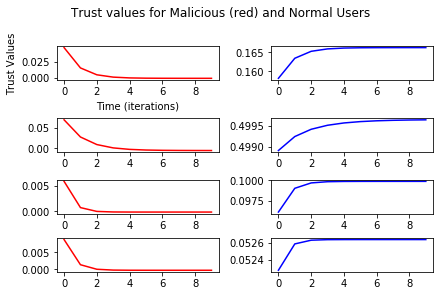

In [46]:
# Trust values over time for different users
# red is malicious
#blue is normal
x = np.arange(0, 10)
fig, ax = plt.subplots(4, 2,constrained_layout=True)
fig.suptitle('Trust values for Malicious (red) and Normal Users')
ax[0][0].set_xlabel('Time (iterations)')
ax[0][0].set_ylabel('Trust Values')

ax[0][0].plot(x, data[8,0:10,2], c = "r")
ax[0][1].plot(x, data[3,0:10,2], c = "b")
ax[1][0].plot(x, data[18,0:10,2], c = "r")
ax[1][1].plot(x, data[10,0:10,2], c = "b")

ax[2][0].plot(x, data[25,0:10,2], c = "r")
ax[2][1].plot(x, data[30,0:10,2], c = "b")
ax[3][0].plot(x,data[58,0:10,2], c = "r")
ax[3][1].plot(x, data[59,0:10,2], c = "b")

In [28]:
malicious_users

[1, 8, 18, 19, 25, 29, 36, 38, 54, 55, 58]